In [16]:
"""
Global Tactical Asset Allocation 

Long Only 

Instrumentos Usados:

1.  Equities - US Large Cap Value - $VTV, creado en 2004.
2.  Equities - US Large Cap Growth - $VUG, creado en 2004. 
3.  Equities - US Small Cap Value - $VBR, creado en 2004. 
4.  Equities - US Small Cap Growth -  $VBK, creado en 2004. 
5.  Equities - Developed countries ex-US - $VEA, creado en 2007. 
6.  Equities - Emerging markets - $VWO, creado en 2005.
7.  Bonds - US 10Y Goverment Bonds - $IEF, creado en 2002. 
8.  Bonds - Euro 10Y Goverment Bonds - $SXRQ.DE, creado en 2009.
9.  Bonds - US Corporate Bonds - $LQD, creado en 2002.
10. Bonds - US 20Y+ Goverment Bonds -  $TLT, creado en 2002.
11. Commodities - Goldman Sachs Commodity Index - $GSG, creado en 2006.
12. Commodities - Gold - $GLD, creado en 2004.

"""

'\nGlobal Tactical Asset Allocation \n\nLong Only \n\nInstrumentos Usados:\n\n1.  Equities - US Large Cap Value - $VTV, creado en 2004.\n2.  Equities - US Large Cap Growth - $VUG, creado en 2004. \n3.  Equities - US Small Cap Value - $VBR, creado en 2004. \n4.  Equities - US Small Cap Growth -  $VBK, creado en 2004. \n5.  Equities - Developed countries ex-US - $VEA, creado en 2007. \n6.  Equities - Emerging markets - $VWO, creado en 2005.\n7.  Bonds - US 10Y Goverment Bonds - $IEF, creado en 2002. \n8.  Bonds - Euro 10Y Goverment Bonds - $SXRQ.DE, creado en 2009.\n9.  Bonds - US Corporate Bonds - $LQD, creado en 2002.\n10. Bonds - US 20Y+ Goverment Bonds -  $TLT, creado en 2002.\n11. Commodities - Goldman Sachs Commodity Index - $GSG, creado en 2006.\n12. Commodities - Gold - $GLD, creado en 2004.\n\n'

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyomo.environ import *

In [ ]:
#Formula para creación de un modelo basado en Kelly Criterion
def buildKCOptModel(returns: np.array, varcov: np.matrix, 
                    rfr: float = 0):
  assert returns.shape[0] == varcov.shape[0]
  assert returns.shape[0] == varcov.shape[1]

  m = ConcreteModel()

  # Indices
  m.i = RangeSet(0, returns.shape[0] - 1)

  # Decision variables
  m.f = Var(m.i, domain=UnitInterval)

  # Parameters
  m.mu = Param(m.i, 
               initialize={i: m for i, m in zip(m.i, returns)})
  m.sigma = Param(m.i, m.i, 
                  initialize={(i, j): varcov[i, j] 
                              for i in m.i 
                              for j in m.i})

  # Constraints
  @m.Constraint()
  def fullyInvestedConstraint(m):
    return sum(m.f[i] for i in m.i) == 1

  # Objective
  @m.Objective(sense=maximize)
  def objective(m):
    return (rfr + sum(m.f[i] * (m.mu[i] - rfr) for i in m.i) - \
            sum(
                sum(m.f[i] * m.sigma[i, j] * m.f[j] for j in m.i)
            for i in m.i) / 2)
  
  return m

# Devuelve
def getKCOpt(data: pd.DataFrame, lookback=252, rfr=0):
  returns = data.loc[:, (slice(None), 'Close')] / \
    data.loc[:, (slice(None), 'Close')].shift(1)
  returns = returns.rename(columns={'Close': 'returns'})
  means = returns.rolling(lookback).mean().rename(
    columns={'returns': 'mean'})
  var = returns.rolling(lookback).var().rename(
    columns={'returns': 'var'})
  df = pd.concat([returns, means, var], axis=1)
  # Get covariance matrices and transform to 3D array
  n = returns.shape[1]
  cov = returns.droplevel(1, axis=1).rolling(lookback).cov().values.reshape(
      -1, n, n)
  
  fracs = np.zeros((df.shape[0], n))
  fracs[:] = np.nan
  g = np.zeros(df.shape[0])
  g[:] = np.nan

  for i, (ts, row) in enumerate(df.iterrows()):
    if i < lookback:
      continue
    means = row.loc[(slice(None), 'mean')].values
    var = row.loc[(slice(None), 'var')].values
    varcov = cov[i]
    np.fill_diagonal(varcov, var)
    model = buildKCOptModel(means, varcov, rfr)
    results = SolverFactory('ipopt').solve(model)
    fracs[i] = np.array([model.f[j].value for j in model.f])
    g[i] = model.objective.expr()

  df_fracs = pd.DataFrame(fracs, columns=returns.columns, 
                          index=returns.index).rename(
                              columns={'returns': 'fraction'})
  df_g = pd.DataFrame(g, index=returns.index)
  df_g.columns = pd.MultiIndex.from_arrays(
      [['g'], ['g']])

  return pd.concat([data, df, df_fracs, df_g], axis=1)

In [18]:
ticker_universe = ['VTV','VUG','VBR','VBK','VEA','VWO','IEF','SXRQ.DE','LQD','TLT','GSG','GLD']

fecha_fin_calculo = (datetime.now() - timedelta(days= 1)).strftime('%Y-%m-%d')
fecha_inicio_calculo = '2010-01-01'
multiple = yf.download(ticker_universe, start=fecha_inicio_calculo, end=fecha_fin_calculo)

[*********************100%%**********************]  12 of 12 completed


In [19]:
df_closes = multiple['Adj Close'].copy()
df_closes.fillna(method='bfill',inplace=True)

C:\Users\ftgon\AppData\Local\Temp\ipykernel_8064\3890518869.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_closes.fillna(method='bfill',inplace=True)


In [20]:
for etf in ticker_universe:
    df_closes[f'{etf}_SMA200'] = df_closes[etf].rolling(window = 200).mean()

df_closes.dropna(inplace=True)


In [21]:
for etf in ticker_universe:
    df_closes[f'{etf}_signal'] = np.where(df_closes[etf] > df_closes[f'{etf}_SMA200'], 1, 0)

In [22]:
df_closes

Ticker,GLD,GSG,IEF,LQD,SXRQ.DE,TLT,VBK,VBR,VEA,VTV,...,VBR_signal,VBK_signal,VEA_signal,VWO_signal,IEF_signal,SXRQ.DE_signal,LQD_signal,TLT_signal,GSG_signal,GLD_signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-11,132.289993,31.059999,75.715988,69.687950,110.739998,71.924751,61.577488,45.499733,23.147919,34.992027,...,1,1,1,1,1,1,1,1,1,1
2010-10-12,131.960007,31.129999,75.496590,69.583298,110.940002,71.214066,61.838558,45.618752,23.102615,35.125244,...,1,1,1,1,1,1,1,1,1,1
2010-10-13,134.070007,31.370001,75.496590,69.546349,110.699997,71.103645,62.675812,46.236126,23.361464,35.307529,...,1,1,1,1,1,1,1,1,1,1
2010-10-14,134.750000,31.320000,75.065407,68.986168,110.739998,70.041084,62.513756,46.169186,23.516779,35.125244,...,1,1,1,1,1,1,1,1,1,1
2010-10-15,133.679993,30.889999,74.740082,68.549133,110.470001,69.185501,62.450741,45.975796,23.477953,34.935936,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,232.759995,21.450001,97.380219,111.622009,150.050003,97.821648,262.059998,197.649994,52.139999,170.710007,...,1,1,1,1,1,1,1,1,1,1
2024-08-27,233.389999,21.320000,97.340332,111.532341,149.500000,97.652199,260.809998,196.830002,52.340000,170.789993,...,1,1,1,1,1,1,1,1,0,1
2024-08-28,231.750000,21.070000,97.290489,111.303177,149.815002,97.532585,258.140015,196.300003,52.080002,170.619995,...,1,1,1,1,1,1,1,1,0,1


In [23]:
df_ponderaciones = pd.DataFrame(index=df_closes.index) 
#Ponderaciones fijas
ticker_universe = ['VTV','VUG','VBR','VBK','VEA','VWO','IEF','SXRQ.DE','LQD','TLT','GSG','GLD']

df_ponderaciones['VTV'] = 0.05
df_ponderaciones['VUG'] = 0.05
df_ponderaciones['VBR'] = 0.05
df_ponderaciones['VBK'] = 0.05
df_ponderaciones['VEA'] = 0.10
df_ponderaciones['VWO'] = 0.10
df_ponderaciones['IEF'] = 0.05
df_ponderaciones['SXRQ.DE'] = 0.1
df_ponderaciones['LQD'] = 0.1
df_ponderaciones['TLT'] = 0.05
df_ponderaciones['GSG'] = 0.15
df_ponderaciones['GLD'] = 0.15

In [24]:
df_closes

Ticker,GLD,GSG,IEF,LQD,SXRQ.DE,TLT,VBK,VBR,VEA,VTV,...,VBR_signal,VBK_signal,VEA_signal,VWO_signal,IEF_signal,SXRQ.DE_signal,LQD_signal,TLT_signal,GSG_signal,GLD_signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-11,132.289993,31.059999,75.715988,69.687950,110.739998,71.924751,61.577488,45.499733,23.147919,34.992027,...,1,1,1,1,1,1,1,1,1,1
2010-10-12,131.960007,31.129999,75.496590,69.583298,110.940002,71.214066,61.838558,45.618752,23.102615,35.125244,...,1,1,1,1,1,1,1,1,1,1
2010-10-13,134.070007,31.370001,75.496590,69.546349,110.699997,71.103645,62.675812,46.236126,23.361464,35.307529,...,1,1,1,1,1,1,1,1,1,1
2010-10-14,134.750000,31.320000,75.065407,68.986168,110.739998,70.041084,62.513756,46.169186,23.516779,35.125244,...,1,1,1,1,1,1,1,1,1,1
2010-10-15,133.679993,30.889999,74.740082,68.549133,110.470001,69.185501,62.450741,45.975796,23.477953,34.935936,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,232.759995,21.450001,97.380219,111.622009,150.050003,97.821648,262.059998,197.649994,52.139999,170.710007,...,1,1,1,1,1,1,1,1,1,1
2024-08-27,233.389999,21.320000,97.340332,111.532341,149.500000,97.652199,260.809998,196.830002,52.340000,170.789993,...,1,1,1,1,1,1,1,1,0,1
2024-08-28,231.750000,21.070000,97.290489,111.303177,149.815002,97.532585,258.140015,196.300003,52.080002,170.619995,...,1,1,1,1,1,1,1,1,0,1


In [25]:
df_closes['Equity']= np.nan
df_closes.loc[df_closes.index[0],'Equity'] = 50
df_returns = df_closes[ticker_universe].pct_change()
df_returns = df_returns.add_suffix('_Ret')

In [26]:
weight_columns = ticker_universe
ret_columns = [etf + '_Ret' for etf in weight_columns]

# Iterar sobre cada fila a partir de la segunda
for i in range(1, len(df_returns)):
    # Inicializar el valor de Equity para la fila actual
    equity_sum = 0
    
    # Iterar sobre cada ETF para calcular el sumatorio
    for ret_col, weight_col in zip(ret_columns, weight_columns):
        equity_sum += (
            (df_closes.loc[df_closes.index[i - 1], 'Equity'] *
            df_ponderaciones.loc[df_ponderaciones.index[i - 1], weight_col]) *
            df_returns.loc[df_returns.index[i], ret_col] * df_closes.loc[df_closes.index[i - 1], (weight_col+'_signal')]
        )
    
    # Asignar el valor calculado a la columna 'Equity' en la fila actual
    df_closes.loc[df_closes.index[i], 'Equity'] = equity_sum + df_closes.loc[df_closes.index[i - 1], 'Equity']

<Axes: xlabel='Date'>

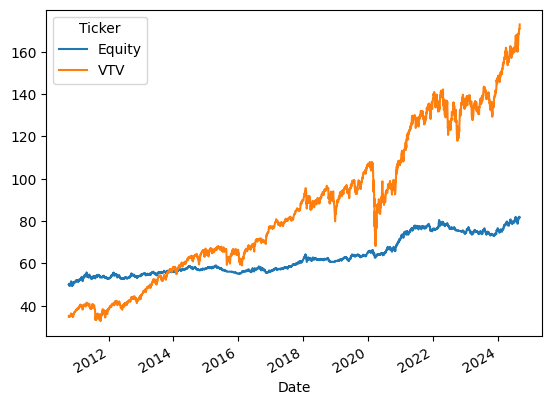

In [27]:
df_closes[['Equity','VTV']].plot()

In [28]:
# Supongamos que df es tu DataFrame y 'equity' es la columna que tiene el valor de equity
valor_inicial = df_closes['Equity'].iloc[0]
valor_final = df_closes['Equity'].iloc[-1]
n = (df_closes.index[-1] - df_closes.index[0]).days / 365.25  # Calcula el número de años

CAGR = (valor_final / valor_inicial) ** (1/n) - 1
print(f"CAGR: {CAGR:.2%}")

CAGR: 3.60%


In [29]:
# Calcular retornos diarios
df_closes['daily_return'] = df_closes['Equity'].pct_change()

# Supongamos que la tasa libre de riesgo anualizada es del 2%
tasa_libre_de_riesgo_anual = 0.02
tasa_libre_de_riesgo_diaria = (1 + tasa_libre_de_riesgo_anual) ** (1/252) - 1  # Aproximación usando 252 días de trading al año

# Calcular retorno promedio y desviación estándar de los retornos diarios
retorno_promedio_diario = df_closes['daily_return'].mean()
desviacion_estandar_diaria = df_closes['daily_return'].std()

# Calcular el Sharpe Ratio anualizado
sharpe_ratio = (retorno_promedio_diario - tasa_libre_de_riesgo_diaria) / desviacion_estandar_diaria
sharpe_ratio_anualizado = sharpe_ratio * np.sqrt(252)  # Ajuste para el año

print(f"Sharpe Ratio Anualizado: {sharpe_ratio_anualizado:.2f}")


Sharpe Ratio Anualizado: 0.29


In [30]:
volatilidad_anualizada = df_closes['daily_return'].std() * np.sqrt(252)
print(f"Volatilidad Anualizada: {volatilidad_anualizada:.2%}")

# Calcular el Drawdown (disminución desde el pico)
df_closes['cumulative_max'] = df_closes['Equity'].cummax()
df_closes['drawdown'] = df_closes['Equity'] / df_closes['cumulative_max'] - 1

# Calcular el Drawdown máximo
max_drawdown = df_closes['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Volatilidad Anualizada: 5.63%
Maximum Drawdown: -9.39%
